In [5]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.tri as tri
from scipy import stats
from sklearn.metrics import confusion_matrix
from scipy.special import gamma as gamma_fun
import scipy.special as spec
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np


from deep_bayes.models import DeepEvidentialModel
from deep_bayes.settings import EVIDENTIAL_HH 
from deep_bayes.training import train_online
from deep_bayes.losses import log_loss
from deep_bayes.viz import plot_model_samples, plot_confusion_matrix
from deep_bayes.diagnostics import accuracy, expected_calibration_error, overconfidence

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
tf.enable_eager_execution()

In [8]:
%matplotlib inline

# Generative model specifications

## Model prior 
<p>Defines the prior probabilities over models $p(\boldsymbol{m})$.</p>

In [9]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    n_models   : int  -- the number of generative models in queston
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

## Model parameters priors
<p>Defines how parameters are generated given a model $p(\boldsymbol{\theta}|\boldsymbol{m})$.</p>

In [10]:
def model1_params_prior(**args):
    """
    Samples from the prior of the HH-2pars theta = (gbar_Na,gbar_K)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = [
         np.random.uniform(low=1.5, high=30), 
         np.random.uniform(low=0.3, high=15)
    ]
    return np.array(theta)


def model2_params_prior(**args):
    """
     Samples from the prior of the HH-3pars theta = (gbar_Na,gbar_K,gbar_M)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = [
        np.random.uniform(low=1.5, high=30), 
        np.random.uniform(low=0.3, high=15),
        np.random.uniform(low=0.005, high=0.3)  
    ]
    return np.array(theta)


def model3_params_prior(**args):
    """
    Samples from the prior of the HH-4pars theta = (gbar_l,gbar_Na,gbar_K,gbar_M)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = [
        np.random.uniform(low=0.01, high=0.18),
        np.random.uniform(low=1.5, high=30), 
        np.random.uniform(low=0.1, high=15),
        np.random.uniform(low=0.005, high=0.3)
    ]
    return np.array(theta)

## Generative models
<p>Defines how the data are generated, that is, $\boldsymbol{x}_{1:N} \sim p(\boldsymbol{x}|boldsymbol{\theta},\boldsymbol{m}).$

In [11]:
from numba import njit

@njit
def forward_model1(params, V0=-70, I_input=3, I_duration=200, dt=0.2):
    
    # HH-2pars    

    # pars = [gbar_Na, gbar_K]
    # I_input = input current in muA/cm2
    # I_duration = duration of current input in ms
    # dt = dt
    
    gbar_Na, gbar_K = params


    # fixed parameters
    tau_max = 6e2   # ms
    Vt = -60.       # mV
    nois_fact = 0.1 # uA/cm2
    E_leak = -70.   # mV
    E_Na = 53       # mV
    E_K = -107      # mV
    C = 1
    g_l = 0.1
    gbar_M = 0.07

    tstep = float(dt)
    
    ####################################
    # Current (I) muA/cm2
    t_on = 10
    t_off = I_duration + 10
    t = np.arange(0, t_on+t_off+dt, dt)
    I = np.zeros_like(t)
    I[int(np.round(t_on/dt)):int(np.round(t_off/dt))] = I_input

    ####################################
    # kinetics
    def efun(z):
        if np.abs(z) < 1e-4:
            return 1 - z/2
        else:
            return z / (np.exp(z) - 1)

    def alpha_m(x):
        v1 = x - Vt - 13.
        return 0.32*efun(-0.25*v1)/0.25

    def beta_m(x):
        v1 = x - Vt - 40
        return 0.28*efun(0.2*v1)/0.2

    def alpha_h(x):
        v1 = x - Vt - 17.
        return 0.128*np.exp(-v1/18.)

    def beta_h(x):
        v1 = x - Vt - 40.
        return 4.0/(1 + np.exp(-0.2*v1))

    def alpha_n(x):
        v1 = x - Vt - 15.
        return 0.032*efun(-0.2*v1)/0.2

    def beta_n(x):
        v1 = x - Vt - 10.
        return 0.5*np.exp(-v1/40)

    # steady-states and time constants
    def tau_n(x):
         return 1/(alpha_n(x) + beta_n(x))
    def n_inf(x):
        return alpha_n(x)/(alpha_n(x) + beta_n(x))
    def tau_m(x):
        return 1/(alpha_m(x) + beta_m(x))
    def m_inf(x):
        return alpha_m(x)/(alpha_m(x) + beta_m(x))
    def tau_h(x):
        return 1/(alpha_h(x) + beta_h(x))
    def h_inf(x):
        return alpha_h(x)/(alpha_h(x) + beta_h(x))

    # slow non-inactivating K+
    def p_inf(x):
        v1 = x + 35.
        return 1.0/(1. + np.exp(-0.1*v1))

    def tau_p(x):
        v1 = x + 35.
        return tau_max/(3.3*np.exp(0.05*v1) + np.exp(-0.05*v1))


    ####################################
    # simulation from initial point
    V = np.zeros_like(t) # voltage
    n = np.zeros_like(t)
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    p = np.zeros_like(t)

    V[0] = float(V0)
    n[0] = n_inf(V[0])
    m[0] = m_inf(V[0])
    h[0] = h_inf(V[0])
    p[0] = p_inf(V[0])

    for i in range(1, t.shape[0]):
        tau_V_inv = ( (m[i-1]**3)*gbar_Na*h[i-1]+(n[i-1]**4)*gbar_K+g_l+gbar_M*p[i-1] )/C
        V_inf = ( (m[i-1]**3)*gbar_Na*h[i-1]*E_Na+(n[i-1]**4)*gbar_K*E_K+g_l*E_leak+gbar_M*p[i-1]*E_K
                +I[i-1]+nois_fact*np.random.randn()/(tstep**0.5) )/(tau_V_inv*C)
        V[i] = V_inf + (V[i-1]-V_inf)*np.exp(-tstep*tau_V_inv)
        n[i] = n_inf(V[i])+(n[i-1]-n_inf(V[i]))*np.exp(-tstep/tau_n(V[i]))
        m[i] = m_inf(V[i])+(m[i-1]-m_inf(V[i]))*np.exp(-tstep/tau_m(V[i]))
        h[i] = h_inf(V[i])+(h[i-1]-h_inf(V[i]))*np.exp(-tstep/tau_h(V[i]))
        p[i] = p_inf(V[i])+(p[i-1]-p_inf(V[i]))*np.exp(-tstep/tau_p(V[i]))

    return V


@njit
def forward_model2(params, V0=-70, I_input=3, I_duration=200, dt=0.2):
    
    # HH-3pars    

    # pars = [gbar_Na, gbar_K, gbar_M]
    # I_input = input current in muA/cm2
    # I_duration = duration of current input in ms
    # dt = dt
    
    gbar_Na, gbar_K, gbar_M = params


    # fixed parameters
    tau_max = 6e2   # ms
    Vt = -60.       # mV
    nois_fact = 0.1 # uA/cm2
    E_leak = -70.   # mV
    E_Na = 53       # mV
    E_K = -107      # mV
    C = 1
    g_l = 0.1

    tstep = float(dt)
    
    ####################################
    # Current (I) muA/cm2
    t_on = 10
    t_off = I_duration + 10
    t = np.arange(0, t_on+t_off+dt, dt)
    I = np.zeros_like(t)
    I[int(np.round(t_on/dt)):int(np.round(t_off/dt))] = I_input

    ####################################
    # kinetics
    def efun(z):
        if np.abs(z) < 1e-4:
            return 1 - z/2
        else:
            return z / (np.exp(z) - 1)

    def alpha_m(x):
        v1 = x - Vt - 13.
        return 0.32*efun(-0.25*v1)/0.25

    def beta_m(x):
        v1 = x - Vt - 40
        return 0.28*efun(0.2*v1)/0.2

    def alpha_h(x):
        v1 = x - Vt - 17.
        return 0.128*np.exp(-v1/18.)

    def beta_h(x):
        v1 = x - Vt - 40.
        return 4.0/(1 + np.exp(-0.2*v1))

    def alpha_n(x):
        v1 = x - Vt - 15.
        return 0.032*efun(-0.2*v1)/0.2

    def beta_n(x):
        v1 = x - Vt - 10.
        return 0.5*np.exp(-v1/40)

    # steady-states and time constants
    def tau_n(x):
         return 1/(alpha_n(x) + beta_n(x))
    def n_inf(x):
        return alpha_n(x)/(alpha_n(x) + beta_n(x))
    def tau_m(x):
        return 1/(alpha_m(x) + beta_m(x))
    def m_inf(x):
        return alpha_m(x)/(alpha_m(x) + beta_m(x))
    def tau_h(x):
        return 1/(alpha_h(x) + beta_h(x))
    def h_inf(x):
        return alpha_h(x)/(alpha_h(x) + beta_h(x))

    # slow non-inactivating K+
    def p_inf(x):
        v1 = x + 35.
        return 1.0/(1. + np.exp(-0.1*v1))

    def tau_p(x):
        v1 = x + 35.
        return tau_max/(3.3*np.exp(0.05*v1) + np.exp(-0.05*v1))


    ####################################
    # simulation from initial point
    V = np.zeros_like(t) # voltage
    n = np.zeros_like(t)
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    p = np.zeros_like(t)

    V[0] = float(V0)
    n[0] = n_inf(V[0])
    m[0] = m_inf(V[0])
    h[0] = h_inf(V[0])
    p[0] = p_inf(V[0])

    for i in range(1, t.shape[0]):
        tau_V_inv = ( (m[i-1]**3)*gbar_Na*h[i-1]+(n[i-1]**4)*gbar_K+g_l+gbar_M*p[i-1] )/C
        V_inf = ( (m[i-1]**3)*gbar_Na*h[i-1]*E_Na+(n[i-1]**4)*gbar_K*E_K+g_l*E_leak+gbar_M*p[i-1]*E_K
                +I[i-1]+nois_fact*np.random.randn()/(tstep**0.5) )/(tau_V_inv*C)
        V[i] = V_inf + (V[i-1]-V_inf)*np.exp(-tstep*tau_V_inv)
        n[i] = n_inf(V[i])+(n[i-1]-n_inf(V[i]))*np.exp(-tstep/tau_n(V[i]))
        m[i] = m_inf(V[i])+(m[i-1]-m_inf(V[i]))*np.exp(-tstep/tau_m(V[i]))
        h[i] = h_inf(V[i])+(h[i-1]-h_inf(V[i]))*np.exp(-tstep/tau_h(V[i]))
        p[i] = p_inf(V[i])+(p[i-1]-p_inf(V[i]))*np.exp(-tstep/tau_p(V[i]))

    return V


@njit
def forward_model3(params, V0=-70, I_input=3, I_duration=200, dt=0.2):
    
    # HH-4pars    

    # pars = [gbar_l, gbar_Na, gbar_K, gbar_M]
    # I_input = input current in muA/cm2
    # I_duration = duration of current input in ms
    # dt = dt
    
    g_l, gbar_Na, gbar_K, gbar_M = params


    # fixed parameters
    tau_max = 6e2   # ms
    Vt = -60.       # mV
    nois_fact = 0.1 # uA/cm2
    E_leak = -70.   # mV
    E_Na = 53       # mV
    E_K = -107      # mV
    C = 1

    tstep = float(dt)
    
    ####################################
    # Current (I) muA/cm2
    t_on = 10
    t_off = I_duration + 10
    t = np.arange(0, t_on+t_off+dt, dt)
    I = np.zeros_like(t)
    I[int(np.round(t_on/dt)):int(np.round(t_off/dt))] = I_input

    ####################################
    # kinetics
    def efun(z):
        if np.abs(z) < 1e-4:
            return 1 - z/2
        else:
            return z / (np.exp(z) - 1)

    def alpha_m(x):
        v1 = x - Vt - 13.
        return 0.32*efun(-0.25*v1)/0.25

    def beta_m(x):
        v1 = x - Vt - 40
        return 0.28*efun(0.2*v1)/0.2

    def alpha_h(x):
        v1 = x - Vt - 17.
        return 0.128*np.exp(-v1/18.)

    def beta_h(x):
        v1 = x - Vt - 40.
        return 4.0/(1 + np.exp(-0.2*v1))

    def alpha_n(x):
        v1 = x - Vt - 15.
        return 0.032*efun(-0.2*v1)/0.2

    def beta_n(x):
        v1 = x - Vt - 10.
        return 0.5*np.exp(-v1/40)

    # steady-states and time constants
    def tau_n(x):
         return 1/(alpha_n(x) + beta_n(x))
    def n_inf(x):
        return alpha_n(x)/(alpha_n(x) + beta_n(x))
    def tau_m(x):
        return 1/(alpha_m(x) + beta_m(x))
    def m_inf(x):
        return alpha_m(x)/(alpha_m(x) + beta_m(x))
    def tau_h(x):
        return 1/(alpha_h(x) + beta_h(x))
    def h_inf(x):
        return alpha_h(x)/(alpha_h(x) + beta_h(x))

    # slow non-inactivating K+
    def p_inf(x):
        v1 = x + 35.
        return 1.0/(1. + np.exp(-0.1*v1))

    def tau_p(x):
        v1 = x + 35.
        return tau_max/(3.3*np.exp(0.05*v1) + np.exp(-0.05*v1))


    ####################################
    # simulation from initial point
    V = np.zeros_like(t) # voltage
    n = np.zeros_like(t)
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    p = np.zeros_like(t)

    V[0] = float(V0)
    n[0] = n_inf(V[0])
    m[0] = m_inf(V[0])
    h[0] = h_inf(V[0])
    p[0] = p_inf(V[0])

    for i in range(1, t.shape[0]):
        tau_V_inv = ( (m[i-1]**3)*gbar_Na*h[i-1]+(n[i-1]**4)*gbar_K+g_l+gbar_M*p[i-1] )/C
        V_inf = ( (m[i-1]**3)*gbar_Na*h[i-1]*E_Na+(n[i-1]**4)*gbar_K*E_K+g_l*E_leak+gbar_M*p[i-1]*E_K
                +I[i-1]+nois_fact*np.random.randn()/(tstep**0.5) )/(tau_V_inv*C)
        V[i] = V_inf + (V[i-1]-V_inf)*np.exp(-tstep*tau_V_inv)
        n[i] = n_inf(V[i])+(n[i-1]-n_inf(V[i]))*np.exp(-tstep/tau_n(V[i]))
        m[i] = m_inf(V[i])+(m[i-1]-m_inf(V[i]))*np.exp(-tstep/tau_m(V[i]))
        h[i] = h_inf(V[i])+(h[i-1]-h_inf(V[i]))*np.exp(-tstep/tau_h(V[i]))
        p[i] = p_inf(V[i])+(p[i-1]-p_inf(V[i]))*np.exp(-tstep/tau_p(V[i]))

    return V

## Data generator
<p>Define the algorithm:</p>
1. <strong>for</strong> $i = 1,...,B$<br>
2. &emsp;$\boldsymbol{m}^{(i)} \sim p(\boldsymbol{m})$<br>
3. &emsp;$\boldsymbol{\theta}^{(i)} \sim p(\boldsymbol{\theta}|\boldsymbol{m}^{(i)})$<br>
4. &emsp;$\boldsymbol{x}_{1:N}^{(i)} \sim p(\boldsymbol{x}|\boldsymbol{\theta}^{(i)},\boldsymbol{m}^{(i)})$

In [12]:
def data_generator(batch_size, model_prior, param_priors, forward_models, alpha_smooth=None,
                   I_duration=None, I_duration_min=100, I_duration_max=500, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size     : int -- the number of samples to draw from the prior
    model_prior    : callable -- the prior which returns a sample of model indices
    param_priors   : list of callables -- a list with model prior samplers
    forward_models : list of generative models g(theta) -- a list of generatibve models
    alpha_smooth   : float or None -- the label smoothing hyperparameter
    n_obs          : int -- the numebr of observations to draw from p(x|theta)
    n_obs_min      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    n_obs_max      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    to_tensor      : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    m     : tf.Tensor or np.ndarray of shape (batch_size, n_models) - the one-hot encoded version of the models
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from model prior
    # m_indices is an np.int32 array of model indices  
    n_models = len(forward_models)
    m_indices = model_prior(batch_size, n_models)
    
    # Sample N, if not specified
    if I_duration is None:
        I_duration = np.random.randint(low=I_duration_min, high=I_duration_max+1)
    
    
    # For each model index, sample from prior and run generative model.
    x = []
    theta = []
    for m_idx in m_indices:
        
        # Draw from model prior theta ~ p(theta|
        theta_m = param_priors[m_idx]()
        
        # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
        x_m = forward_models[m_idx](theta_m, I_duration=I_duration)[:, np.newaxis] 
        
        # Store data and params
        x.append(x_m)
        theta.append(theta_m)
    
    # One-hot encode model indices
    m = to_categorical(m_indices, num_classes=n_models)
    
    # Stote x into a tensor
    x = np.array(x)
    
    # Apply label smoothing, if specified
    if alpha_smooth is not None:
        m = m * (1 - alpha_smooth) + alpha_smooth / n_models
    
    # Convert to tensor, if specified 
    if to_tensor:
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        m = tf.convert_to_tensor(m, dtype=tf.float32)
    return {'m': m, 'theta': theta, 'x': x}

# Training hyperparameters

In [13]:
#--- Training hyperparameters ---#
ckpt_file = "evidential_model_selection_hh"
batch_size = 32
epochs = 50
iterations_per_epoch = 1000
I_duration_max = 400
I_duration_min = 100
n_test = 300


#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.0001
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


#--- Generative model hyperparameters ---#
model_names = ['M1', 'M2', 'M3']
param_priors = [model1_params_prior, model2_params_prior, model3_params_prior]
forward_models = [forward_model1, forward_model2, forward_model3]
data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   I_duration_min=I_duration_min,
                   I_duration_max=I_duration_max)

## Create test data

In [14]:
%%time
test_data = data_gen(n_test, I_duration=200)
test_data_cal = data_gen(5000, I_duration=400)

Wall time: 14.4 s


## Create model

In [15]:
model = DeepEvidentialModel(EVIDENTIAL_HH)

## Manage checkpoints

In [16]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/evidential_model_selection_hh\ckpt-57


# Train network

In [21]:
# for ep in range(1, 1+1):
#     with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
#         losses = train_online(model=model, 
#                               optimizer=optimizer, 
#                               data_gen=data_gen, 
#                               loss_fun=partial(log_loss, lambd=0.0), 
#                               iterations=iterations_per_epoch,
#                               batch_size=batch_size,
#                               p_bar=p_bar,
#                               global_step=global_step,
#                               method='evidence')
        
        
#         # Plot stuff
#         m_pred = model(test_data['x'])['m_probs']
#         plot_confusion_matrix(m_pred.numpy().argmax(axis=1), test_data['m'], model_names, figsize=(8,4),normalize=True)
#         print(accuracy(test_data['m'], m_pred))
                

#         # Store checkpoint
#         manager.save()

# Validate evidential network

## Plot some datasets

In [17]:
params_1 = np.array([3, 2])
params_2 = np.array([3, 2, 0.1])
params_3 = np.array([0.1, 3, 2, 0.1])
I_duration = 200
t = np.linspace(0, 400, 1051)

x1 = forward_model1(params_1, I_duration=I_duration)
x2 = forward_model2(params_2, I_duration=I_duration)
x3 = forward_model3(params_3, I_duration=I_duration)

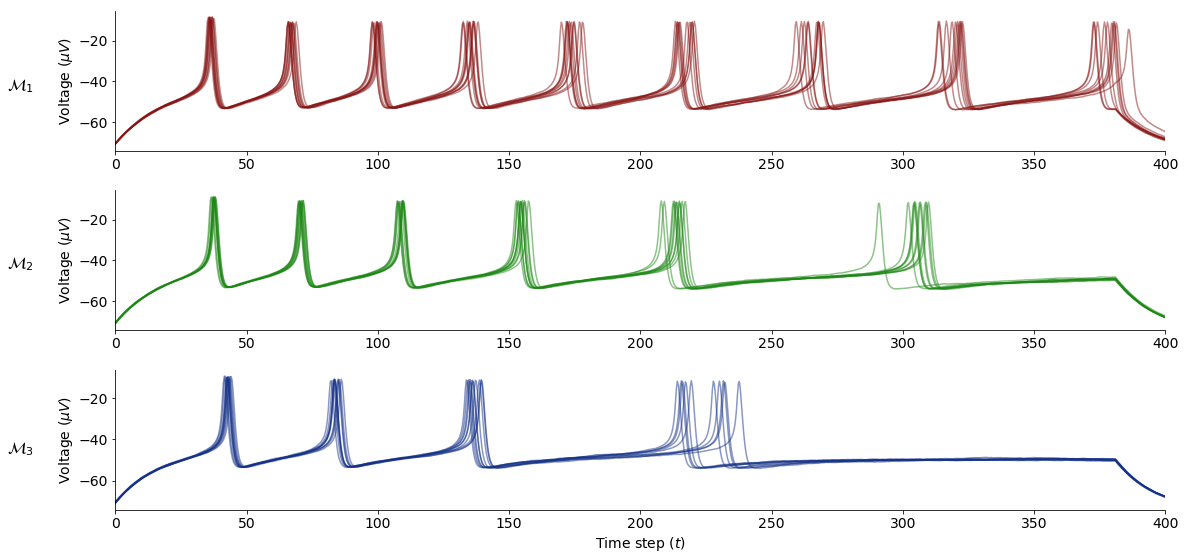

In [156]:
params_1 = np.array([3, 2])
params_2 = np.array([3, 2, 0.1])
params_3 = np.array([0.11, 3, 2, 0.1])

f, ax = plt.subplots(3, 1, figsize=(16, 8))
for _ in range(10):
    x1 = forward_model1(params_1, I_duration=I_duration)
    x2 = forward_model2(params_2, I_duration=I_duration)
    x3 = forward_model3(params_3, I_duration=I_duration)
    ax[0].plot(t, x1[50:], label=r'$\mathcal{M}_1$', alpha=0.5, lw=1.5, color='#871414')
    ax[1].plot(t, x2[50:], label=r'$\mathcal{M}_1$', alpha=0.5, lw=1.5, color='#1c8714')
    ax[2].plot(t, x3[50:], label=r'$\mathcal{M}_1$', alpha=0.5, lw=1.5, color='#143187')
    
for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_ylabel(r'Voltage ($\mu V$)', fontsize=14)
    ax[i].set_xlim([0, 400])
    
ax[2].set_xlabel(r'Time step ($t$)', fontsize=14)
f.tight_layout()

plt.gcf().text(-0.03, 0.83, r'$\mathcal{M}_1$', fontsize=16)
plt.gcf().text(-0.03, 0.52, r'$\mathcal{M}_2$', fontsize=16)
plt.gcf().text(-0.03, 0.2, r'$\mathcal{M}_3$', fontsize=16)

f.savefig('figures/HH_out2.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Voltage ($\\mu V$)')

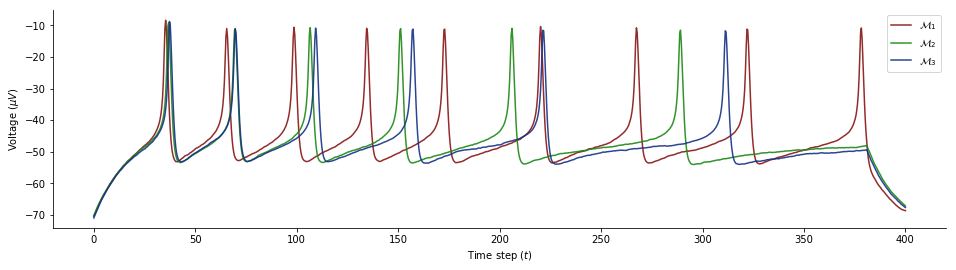

In [18]:
f, ax = plt.subplots(1, 1, figsize=(16, 4))

ax.plot(t, x1[50:], label=r'$\mathcal{M}_1$', alpha=0.9, lw=1.5, color='#871414')
ax.plot(t, x2[50:], label=r'$\mathcal{M}_2$', alpha=0.9, lw=1.5, color='#1c8714')
ax.plot(t, x3[50:], label=r'$\mathcal{M}_3$', alpha=0.9, lw=1.5, color='#143187')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
ax.set_xlabel(r'Time step ($t$)')
ax.set_ylabel(r'Voltage ($\mu V$)')

# f.savefig('figures/HH_out.png', dpi=300, bbox_inches='tight')

## Calibration

In [106]:
n_bins = 10
cal_errs_b = []
cal_probs_b = []

for _ in range(50):
    test_data_cal = data_gen(5000, I_duration=400)
    preds = np.concatenate([model.predict(x, to_numpy=True)['m_probs'] 
                            for x in tf.split(test_data_cal['x'], 20, axis=0)], axis=0)
    cal_errs, cal_probs = expected_calibration_error(test_data_cal['m'], preds, n_bins=n_bins)
    cal_errs_b.append(cal_errs)
    cal_probs_b.append(cal_probs)

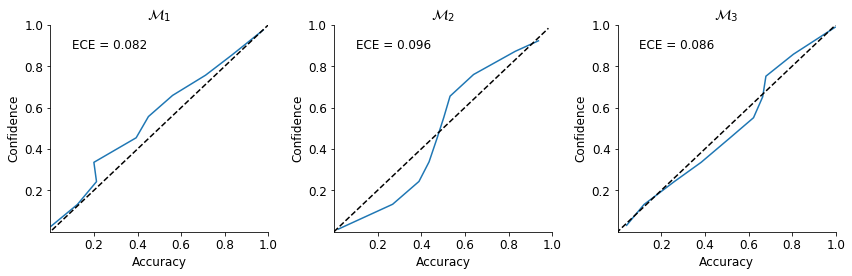

In [182]:

plt.rcParams['font.size'] = 12


ms = [r'$\mathcal{M}_1$', r'$\mathcal{M}_2$', r'$\mathcal{M}_3$']
c = np.array(cal_probs_b).mean(0)
c_std = np.array(cal_probs_b).std(0)
e = np.array(cal_errs_b).mean(0)


# Plot calibration curves
f, axarr = plt.subplots(1, 3, figsize=(12, 4))


# Compute probabilities and calibrations

for i, ax in enumerate(axarr.flat):
    ax.plot(c[i, 0, :], c[i, 1, :])
    ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(model_names[i])
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Confidence')
    ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.text(0.1, 0.9, r'ECE = {0:.3f}'.format(e[i]),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=ax.transAxes,
                     size=12)

for i, ax in enumerate(axarr.flat):
    ax.set_title(ms[i])
f.tight_layout()
f.savefig('figures/hh_calibration.png', dpi=300, bbox_inches='tight')

## Accuracy

In [133]:
accs = []
accs_stds = []
n_bootstrap = 50
n_val = 5000
n_chunks = 10 



for I_duration in range(I_duration_min, I_duration_max+1, 4):
    
    test_data_acc = data_gen(n_val, I_duration=I_duration)
    m_probs = np.concatenate([model.predict(x, to_numpy=True)['m_probs'] 
                              for x in tf.split(test_data_acc['x'], n_chunks, axis=0)], axis=0)
    
    # Compute bootstrapped probs
    accs_b = []
    for bi in range(n_bootstrap):
        
        # Get bootstrap samples
        b_idx = np.random.choice(np.random.permutation(n_val), size=n_val, replace=True)
        m_test_b = tf.gather(test_data_acc['m'], b_idx, axis=0).numpy()
        m_probs_b = tf.gather(m_probs, b_idx, axis=0).numpy()
        acc_b = accuracy(m_test_b, m_probs_b)
        accs_b.append(acc_b)
        
    # Compute true and estimated BFs
    accs.append(np.mean(accs_b))
    accs_stds.append(np.std(accs_b, ddof=1))

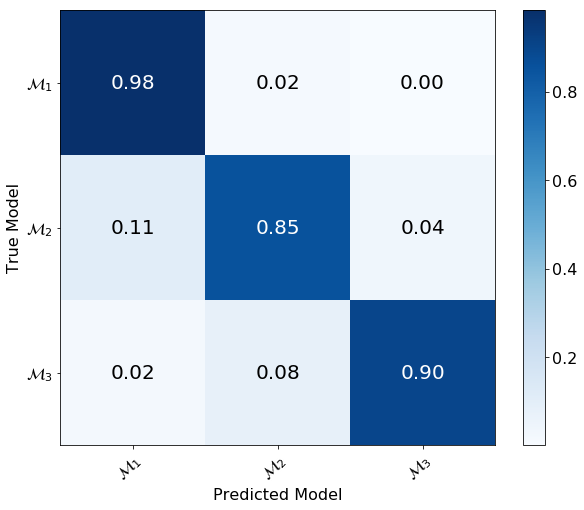

In [70]:
# Take argmax of test
plt.rcParams['font.size'] = 16
test_data_c = data_gen(5000, I_duration=100)
m_pred = tf.concat([model(x)['m_probs'] for x in tf.split(test_data_c['x'], 20, axis=0)], axis=0)
m_test = np.argmax(test_data_c['m'].numpy(), axis=1).astype(np.int32)
ms = [r'$\mathcal{M}_1$', r'$\mathcal{M}_2$', r'$\mathcal{M}_3$']


# Compute confusion matrix
cm = confusion_matrix(m_test, m_pred.numpy().argmax(1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=ms, yticklabels=ms,
           ylabel='True Model',
           xlabel='Predicted Model')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.

fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black", fontsize=20)
fig.savefig('figures/HH_CM.png', dpi=300, bbox_inches='tight')

# Train with KL

In [72]:
#--- Training hyperparameters ---#
ckpt_file = "evidential_model_selection_hh_kl2"
batch_size = 64
epochs = 50
iterations_per_epoch = 1000
I_duration_max = 400
I_duration_min = 100
n_test = 300


#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.00005
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


#--- Generative model hyperparameters ---#
model_names = ['M1', 'M2', 'M3']
param_priors = [model1_params_prior, model2_params_prior, model3_params_prior]
forward_models = [forward_model1, forward_model2, forward_model3]
data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   I_duration_min=I_duration_min,
                   I_duration_max=I_duration_max,
                   I_duration=200)

In [10]:
%%time
test_data = data_gen(n_test, I_duration=200)

Wall time: 9.22 s


In [73]:
model = DeepEvidentialModel(EVIDENTIAL_HH)

In [74]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/evidential_model_selection_hh_kl2\ckpt-57


In [43]:
# for ep in range(1, epochs+1):
#     with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
#         losses = train_online(model=model, 
#                               optimizer=optimizer, 
#                               data_gen=data_gen, 
#                               loss_fun=partial(log_loss, lambd=5.0), 
#                               iterations=iterations_per_epoch,
#                               batch_size=batch_size,
#                               p_bar=p_bar,
#                               global_step=global_step,
#                               method='evidence')
        
        
#         # Plot stuff
#         m_pred = model(test_data['x'])['m_probs']
#         plot_confusion_matrix(m_pred.numpy().argmax(axis=1), test_data['m'], model_names, figsize=(8,4),normalize=True)
#         print(accuracy(test_data['m'], m_pred))
                

#         # Store checkpoint
#         manager.save()

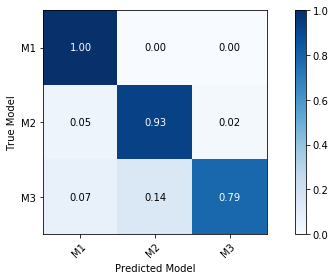

0.9066666666666666


In [119]:
# Plot stuff
m_pred = model(test_data['x'])['m_probs']
plot_confusion_matrix(m_pred.numpy().argmax(axis=1), test_data['m'], model_names, figsize=(8,4),normalize=True)
print(accuracy(test_data['m'], m_pred))

In [75]:
@njit
def forward_model_test(params, V0=-70, I_input=3, nois_fact = 0.1, E_leak = -70., E_K = -107, t_on = 10,
                       I_duration=200, dt=0.2, E_Na = 53, tau_max = 6e2, Vt = -60., C = 1, g_l = 0.1,
                       gbar_M = 0.07):
    
    # HH-2pars    

    # pars = [gbar_Na, gbar_K]
    # I_input = input current in muA/cm2
    # I_duration = duration of current input in ms
    # dt = dt
    
    gbar_Na, gbar_K = params

    tstep = float(dt)
    
    ####################################
    # Current (I) muA/cm2
    t_off = I_duration + 10
    t = np.arange(0, t_on+t_off+dt, dt)
    I = np.zeros_like(t)
    I[int(np.round(t_on/dt)):int(np.round(t_off/dt))] = I_input

    ####################################
    # kinetics
    def efun(z):
        if np.abs(z) < 1e-4:
            return 1 - z/2
        else:
            return z / (np.exp(z) - 1)

    def alpha_m(x):
        v1 = x - Vt - 13.
        return 0.32*efun(-0.25*v1)/0.25

    def beta_m(x):
        v1 = x - Vt - 40
        return 0.28*efun(0.2*v1)/0.2

    def alpha_h(x):
        v1 = x - Vt - 17.
        return 0.128*np.exp(-v1/18.)

    def beta_h(x):
        v1 = x - Vt - 40.
        return 4.0/(1 + np.exp(-0.2*v1))

    def alpha_n(x):
        v1 = x - Vt - 15.
        return 0.032*efun(-0.2*v1)/0.2

    def beta_n(x):
        v1 = x - Vt - 10.
        return 0.5*np.exp(-v1/40)

    # steady-states and time constants
    def tau_n(x):
         return 1/(alpha_n(x) + beta_n(x))
    def n_inf(x):
        return alpha_n(x)/(alpha_n(x) + beta_n(x))
    def tau_m(x):
        return 1/(alpha_m(x) + beta_m(x))
    def m_inf(x):
        return alpha_m(x)/(alpha_m(x) + beta_m(x))
    def tau_h(x):
        return 1/(alpha_h(x) + beta_h(x))
    def h_inf(x):
        return alpha_h(x)/(alpha_h(x) + beta_h(x))

    # slow non-inactivating K+
    def p_inf(x):
        v1 = x + 35.
        return 1.0/(1. + np.exp(-0.1*v1))

    def tau_p(x):
        v1 = x + 35.
        return tau_max/(3.3*np.exp(0.05*v1) + np.exp(-0.05*v1))


    ####################################
    # simulation from initial point
    V = np.zeros_like(t) # voltage
    n = np.zeros_like(t)
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    p = np.zeros_like(t)

    V[0] = float(V0)
    n[0] = n_inf(V[0])
    m[0] = m_inf(V[0])
    h[0] = h_inf(V[0])
    p[0] = p_inf(V[0])
    

    for i in range(1, t.shape[0]):
        tau_V_inv = ( (m[i-1]**3)*gbar_Na*h[i-1]+(n[i-1]**4)*gbar_K+g_l+gbar_M*p[i-1] )/C
        V_inf = ( (m[i-1]**3)*gbar_Na*h[i-1]*E_Na+(n[i-1]**4)*gbar_K*E_K+g_l*E_leak+gbar_M*p[i-1]*E_K
                +I[i-1]+nois_fact*np.random.randn()/(tstep**0.5) )/(tau_V_inv*C)
        V[i] = V_inf + (V[i-1]-V_inf)*np.exp(-tstep*tau_V_inv)
        n[i] = n_inf(V[i])+(n[i-1]-n_inf(V[i]))*np.exp(-tstep/tau_n(V[i]))
        m[i] = m_inf(V[i])+(m[i-1]-m_inf(V[i]))*np.exp(-tstep/tau_m(V[i]))
        h[i] = h_inf(V[i])+(h[i-1]-h_inf(V[i]))*np.exp(-tstep/tau_h(V[i]))
        p[i] = p_inf(V[i])+(p[i-1]-p_inf(V[i]))*np.exp(-tstep/tau_p(V[i]))

    return V

## Explore uncertainty

In [179]:
ps = np.linspace(0.1, 2.0, 25)
n_test = 500
us = []

for p in ps:
    x = tf.concat([tf.convert_to_tensor(
                        forward_model_test(np.array([4., p]))[np.newaxis, :, np.newaxis], dtype=tf.float32
                    ) for _ in range(n_test)], axis=0)
    u = model.predict(x)['uncertainty'].mean()
    us.append(u)

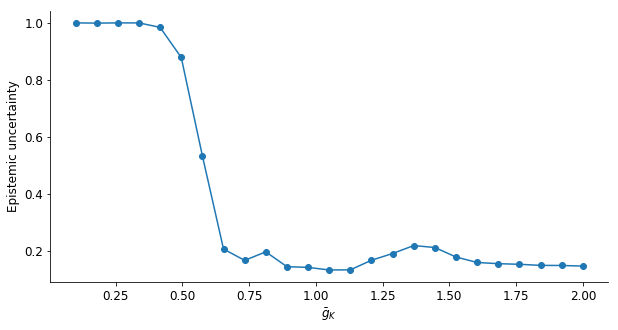

In [181]:
plt.rcParams['font.size'] = 12
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(ps, us, marker='o')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'$\bar{g}_K$')
ax.set_ylabel('Epistemic uncertainty')
f.savefig('figures/hh_ood.png', dpi=300)

In [76]:
from functools import reduce
import math

def xy2bc(xy, corners, midpoints, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

class Dirichlet:
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])
    
def draw_pdf_contours(dist, nlevels=200, subdiv=8, ax=None, f=None, **kwargs):
    
    
    if ax is None and f is None:
        f, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy, corners, midpoints)) for xy in zip(trimesh.x, trimesh.y)]

    ax.tricontourf(trimesh, pvals, nlevels, **kwargs)
    return f

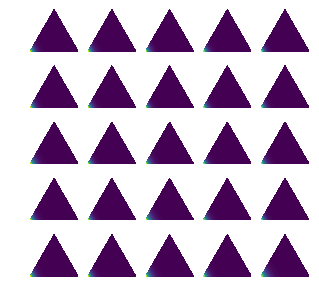

In [135]:
np.random.seed(42)
test =  tf.concat([tf.convert_to_tensor(
                        forward_model_test(np.array([3., 0.75]))[np.newaxis, :, np.newaxis], dtype=tf.float32
                    ) for _ in range(25)], axis=0)
alphas = model(test)['alpha'].numpy()
f, ax = plt.subplots(5, 5, figsize=(5, 5))

for i, alpha in enumerate(alphas):
    d = Dirichlet(alpha)
    draw_pdf_contours(d, n_levels=100, subdiv=8, ax=ax.flat[i], f=f, cmap='viridis')

## Visualize observed data and corresponding evidences

In [143]:
np.random.seed(42)
x = tf.convert_to_tensor(
                        forward_model_test(np.array([4., 0.1]))[np.newaxis, :, np.newaxis], dtype=tf.float32
                    )
alpha = model(x)['alpha'].numpy().flatten()
x2 = tf.convert_to_tensor(
                        forward_model_test(np.array([4., 0.5]))[np.newaxis, :, np.newaxis], dtype=tf.float32
                    )
alpha2 = model(x2)['alpha'].numpy().flatten()
x3 = tf.convert_to_tensor(
                        forward_model_test(np.array([4., 0.75]))[np.newaxis, :, np.newaxis], dtype=tf.float32
                    )
alpha3 = model(x3)['alpha'].numpy().flatten()

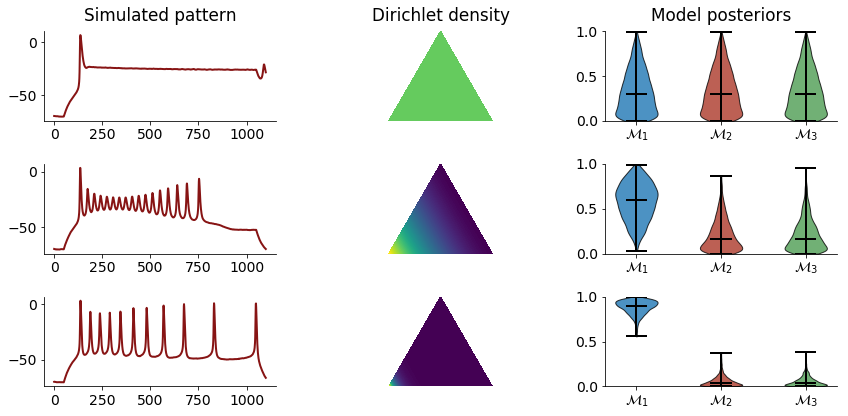

In [154]:
plt.rcParams['font.size'] = 14
f, ax = plt.subplots(3, 3, figsize=(12, 6))

# First row - implausible


## Dataset
ax[0, 0].plot(x.numpy()[0], color='#871414', lw=2)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['top'].set_visible(False)

## Dirichlet
d = Dirichlet(alpha)
draw_pdf_contours(d, n_levels=100, subdiv=8, ax=ax[0, 1], f=f, cmap='viridis')
ax[0, 1].axis('equal')
ax[0, 1].set_xlim([0, 1])
ax[0, 1].set_ylim([0, 0.75**0.5])
ax[0, 1].axis('off')

## Posteriors
d_samples = stats.dirichlet.rvs(alpha, size=7000)
d_samples[:, 1] = d_samples[:, 0] # All alpha1 are 1, so remove noise
d_samples[:, 2] = d_samples[:, 0]
colors = ('#1f77b4', '#ab3829', '#4e9c53')
parts = ax[0, 2].violinplot(d_samples, [0, 1, 2], showmedians=True)
for c, pc in zip(colors, parts['bodies']):
    pc.set_facecolor(c)
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)
    
for partname in ('cbars','cmins','cmaxes', 'cmedians'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(2)
    
ax[0, 2].spines['right'].set_visible(False)
ax[0, 2].spines['top'].set_visible(False)
ax[0, 2].set_xticks([0, 1, 2])
ax[0, 2].set_xticklabels([r'$\mathcal{M}_1$', r'$\mathcal{M}_2$', r'$\mathcal{M}_3$'])
ax[0, 2].set_yticks([0.0, 0.5, 1.0])
ax[0, 2].set_yticklabels([0.0, 0.5, 1.0])
ax[0, 2].set_ylim([0, 1.0])

# Second row - more plausible
## Dataset
ax[1, 0].plot(x2.numpy()[0], color='#871414', lw=2)
ax[1, 0].spines['right'].set_visible(False)
ax[1, 0].spines['top'].set_visible(False)

## Dirichlet
d = Dirichlet(alpha2)
draw_pdf_contours(d, n_levels=100, subdiv=8, ax=ax[1, 1], f=f, cmap='viridis')
ax[1, 1].axis('equal')
ax[1, 1].set_xlim([0, 1])
ax[1, 1].set_ylim([0, 0.75**0.5])
ax[1, 1].axis('off')

## Posteriors
d_samples = stats.dirichlet.rvs(alpha2, size=3000)
colors = ('#1f77b4', '#ab3829', '#4e9c53')
parts = ax[1, 2].violinplot(d_samples, [0, 1, 2], showmedians=True)
for c, pc in zip(colors, parts['bodies']):
    pc.set_facecolor(c)
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)
    
for partname in ('cbars','cmins','cmaxes', 'cmedians'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(2)
    
ax[1, 2].spines['right'].set_visible(False)
ax[1, 2].spines['top'].set_visible(False)
ax[1, 2].set_xticks([0, 1, 2])
ax[1, 2].set_xticklabels([r'$\mathcal{M}_1$', r'$\mathcal{M}_2$', r'$\mathcal{M}_3$'])
ax[1, 2].set_yticks([0.0, 0.5, 1.0])
ax[1, 2].set_yticklabels([0.0, 0.5, 1.0])
ax[1, 2].set_ylim([0, 1.0])

# Third row- clear cut
## Dataset
ax[2, 0].plot(x3.numpy()[0], color='#871414', lw=2)
ax[2, 0].spines['right'].set_visible(False)
ax[2, 0].spines['top'].set_visible(False)

## Dirichlet
d = Dirichlet(alpha3)
draw_pdf_contours(d, n_levels=100, subdiv=8, ax=ax[2, 1], f=f, cmap='viridis')
ax[2, 1].axis('equal')
ax[2, 1].set_xlim([0, 1])
ax[2, 1].set_ylim([0, 0.75**0.5])
ax[2, 1].axis('off')

## Posteriors
d_samples = stats.dirichlet.rvs(alpha3, size=3000)
colors = ('#1f77b4', '#ab3829', '#4e9c53')
parts = ax[2, 2].violinplot(d_samples, [0, 1, 2], showmedians=True)
for c, pc in zip(colors, parts['bodies']):
    pc.set_facecolor(c)
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)
    
for partname in ('cbars','cmins','cmaxes', 'cmedians'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(2)
    
ax[2, 2].spines['right'].set_visible(False)
ax[2, 2].spines['top'].set_visible(False)
ax[2, 2].set_xticks([0, 1, 2])
ax[2, 2].set_xticklabels([r'$\mathcal{M}_1$', r'$\mathcal{M}_2$', r'$\mathcal{M}_3$'])
ax[2, 2].set_yticks([0.0, 0.5, 1.0])
ax[2, 2].set_yticklabels([0.0, 0.5, 1.0])
ax[2, 2].set_ylim([0, 1.0])

ax[0, 0].set_title('Simulated pattern', pad=10)
ax[0, 1].set_title('Dirichlet density', pad=10)
ax[0, 2].set_title('Model posteriors', pad=10)
f.tight_layout()
f.savefig('figures/hh_distros.png', dpi=300)

## Visualize linear increase in implausibility

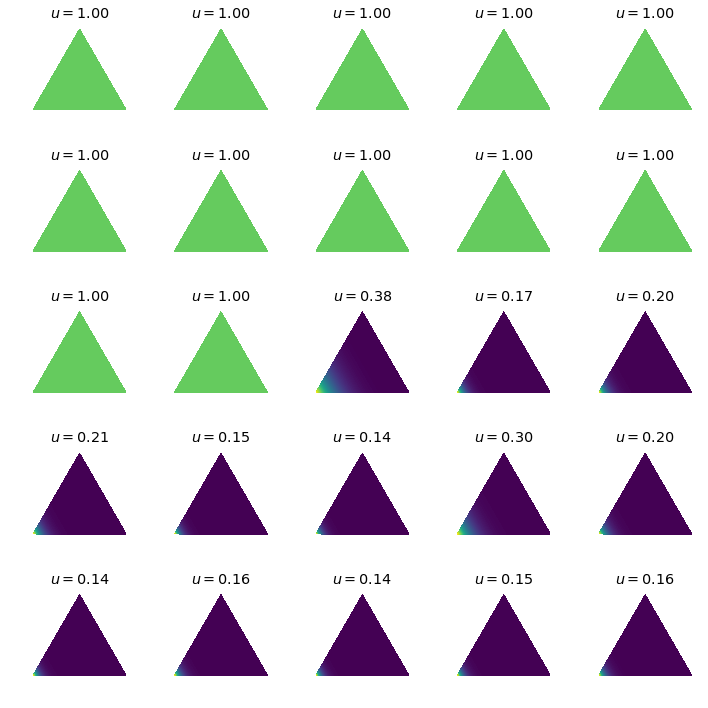

In [182]:
# f, ax = plt.subplots(5, 5, figsize=(10, 10))
# for i, p in enumerate(np.linspace(0.1, 1.0, 25)):
#     np.random.seed(42)
#     x = tf.convert_to_tensor(
#                         forward_model_test(np.array([4., p]))[np.newaxis, :, np.newaxis], dtype=tf.float32
#                     )
#     alpha = model(x)['alpha'].numpy().flatten()
#     d = Dirichlet(alpha)
#     draw_pdf_contours(d, n_levels=100, subdiv=8, ax=ax.flat[i], f=f, cmap='viridis')
#     ax.flat[i].axis('equal')
#     ax.flat[i].set_xlim([0, 1])
#     ax.flat[i].set_ylim([0, 0.75**0.5])
#     ax.flat[i].axis('off')
#     ax.flat[i].set_title(r'$u={0:.2f}$'.format(3/np.sum(alpha)))
# f.tight_layout()

In [183]:
f.savefig('figures/hh_dir.png', dpi=300)